# **Problem Statement :- Build CNN Model for Classification Of Flowers**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Load the dataset**

In [ ]:
!unzip gdrive/My\ Drive/Flowers/flowersdataset.zip

## **Image Augmentation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
import cv2
from tensorflow.keras import layers, models
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import zipfile
tf.__version__

'2.8.2'

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
IMAGE_SIZE = [128, 128]
EPOCHS = 25

In [ ]:
GCS_PATH = "/content/flowers"

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "*/*"))])
CLASS_NAMES

array(['rose', 'daisy', 'dandelion', 'sunflower', 'tulip'], dtype='<U9')

In [ ]:
files_count = []
for i,f in enumerate(CLASS_NAMES):
    folder_path = os.path.join(GCS_PATH, f)
    for path in os.listdir(os.path.join(folder_path)):
        files_count.append(['{}/{}'.format(folder_path,path), f, i])
flowers_df = pd.DataFrame(files_count, columns=['filepath', 'class_name', 'label'])
flowers_df.head()

,filepath,class_name,label
0,/content/flowers/rose/18376177250_86060cbdc9.jpg,rose,0
1,/content/flowers/rose/18741313803_1bbf842fc6_n...,rose,0
2,/content/flowers/rose/21522100663_455b77a90c_n...,rose,0
3,/content/flowers/rose/8523394349_61b31fdd8f_m.jpg,rose,0
4,/content/flowers/rose/3997609936_8db20b7141_n.jpg,rose,0


In [ ]:
flowers_df.class_name.value_counts()

dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: class_name, dtype: int64

In [ ]:
quantidade_por_class = 500
flowers_df = pd.concat([flowers_df[flowers_df['class_name']== i][:quantidade_por_class] for i in CLASS_NAMES])

In [ ]:
flowers_df.class_name.value_counts()

rose         500
daisy        500
dandelion    500
sunflower    500
tulip        500
Name: class_name, dtype: int64

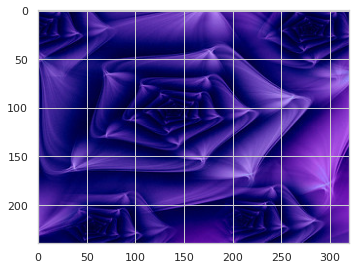

In [ ]:
image = cv2.imread(flowers_df.filepath[100])
imgplot = plt.imshow(image)
plt.show()

## **Create Model**

In [ ]:
X = flowers_df['filepath']
y = flowers_df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
#convert to tensor


x_train_tensor = tf.convert_to_tensor(x_train.values, dtype=tf.string)
y_train_tensor = tf.convert_to_tensor(y_train.values)

x_test_tensor = tf.convert_to_tensor(x_test.values, dtype=tf.string)
y_test_tensor = tf.convert_to_tensor(y_test.values)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor))
test_data = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_tensor))

In [ ]:
def map_fn(path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(path))

    return image, label

#apply the function
train_data_img = train_data.map(map_fn)
test_data_img = test_data.map(map_fn)

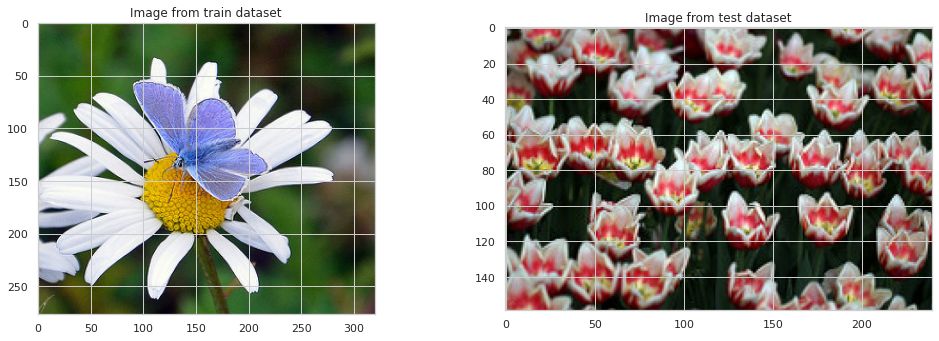

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_img.take(1):
    ax[0].set_title('Image from train dataset');
    ax[0].imshow(i);
for i,l in test_data_img.take(1):
    ax[1].set_title('Image from test dataset');
    ax[1].imshow(i);

In [ ]:
def preprocessing(image, label):
    """
    returns a image that is reshaped and normalized
    """
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label


train_data_norm = train_data_img.map(preprocessing)
test_data_norm = test_data_img.map(preprocessing)

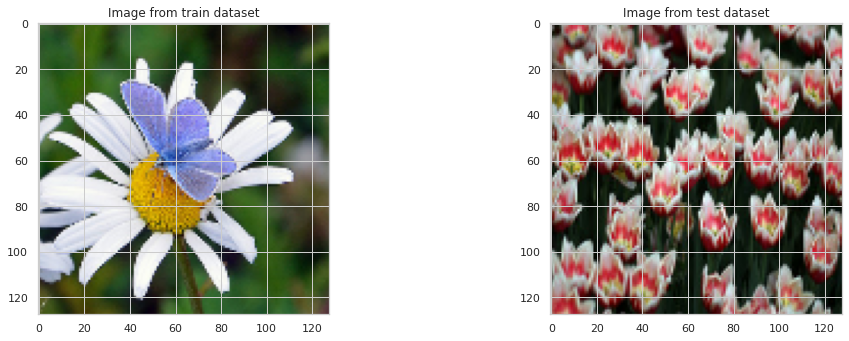

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_norm.take(1):
    ax[0].set_title('Image from train dataset');
    ax[0].imshow(i);
for i,l in test_data_norm.take(1):
    ax[1].set_title('Image from test dataset');
    ax[1].imshow(i);

In [ ]:
train_batches = train_data_norm.batch(batch_size)
test_batches = test_data_norm.batch(batch_size)

for i, l in train_batches.take(1):
    print('Train Data Shape',i.shape)
for i, l in test_batches.take(1):
    print('Test Data Shape',i.shape)

Train Data Shape (32, 128, 128, 3)
Test Data Shape (32, 128, 128, 3)


## **Add Layers**

In [ ]:
LeNet = models.Sequential()
LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
LeNet.add(layers.AveragePooling2D())
LeNet.add(layers.Conv2D(16, (5,5), activation = 'relu'))
LeNet.add(layers.AveragePooling2D())
LeNet.add(layers.Flatten())
LeNet.add(layers.Dense(255, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(124, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(84, activation='relu'))
LeNet.add(layers.Dense(43, activation='sigmoid'))
LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 62, 62, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 29, 29, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 255)               3

## **Compile the Model**

In [ ]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

## **Fit and save the Model**

In [ ]:
history = LeNet.fit(train_batches, epochs=100,batch_size = 16,validation_data=(test_batches))

Epoch 1/100
55/55 [==============================] - 31s 558ms/step - loss: 1.7439 - accuracy: 0.3291 - val_loss: 1.2508 - val_accuracy: 0.4427
Epoch 2/100
55/55 [==============================] - 31s 555ms/step - loss: 1.2467 - accuracy: 0.4846 - val_loss: 1.1939 - val_accuracy: 0.5107
Epoch 3/100
55/55 [==============================] - 30s 554ms/step - loss: 1.1543 - accuracy: 0.5080 - val_loss: 1.1832 - val_accuracy: 0.5133
Epoch 4/100
55/55 [==============================] - 30s 554ms/step - loss: 1.0490 - accuracy: 0.5571 - val_loss: 1.1428 - val_accuracy: 0.5133
Epoch 5/100
55/55 [==============================] - 30s 552ms/step - loss: 0.9805 - accuracy: 0.6011 - val_loss: 1.2055 - val_accuracy: 0.5267
Epoch 6/100
55/55 [==============================] - 30s 555ms/step - loss: 0.8928 - accuracy: 0.6463 - val_loss: 1.1135 - val_accuracy: 0.5400
Epoch 7/100
55/55 [==============================] - 30s 554ms/step - loss: 0.7068 - accuracy: 0.7246 - val_loss: 1.1488 - val_accuracy:

In [ ]:
def process_image(path):
    img = tf.image.decode_image(tf.io.read_file(path))
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, IMAGE_SIZE)
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img, axis=0)
    return img_tensor

## **Test The Model**

In [ ]:
image_pred = process_image(x_test.iloc[152])
#prediction = LeNet.predict_classes(image_pred)[0]
prediction = np.argmax(LeNet.predict(image_pred),axis=1)

print(("The image is a " + str(CLASS_NAMES[prediction])).capitalize())
print(f'The image is predicted as a {CLASS_NAMES[y_test.iloc[152]]}')

The image is a ['dandelion']
The image is predicted as a dandelion
